In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models, datasets
from torch.utils.data import DataLoader
from torchvision.models import ResNet50_Weights

import matplotlib.pyplot as plt
import os
from tqdm import tqdm

# ✅ Set Paths
DATASET_PATH = "D:\Capstone Project\Final coffee leaf_Dataset"
TRAIN_PATH = os.path.join(DATASET_PATH, "train")
VAL_PATH = os.path.join(DATASET_PATH, "val")
TEST_PATH = os.path.join(DATASET_PATH, "test")

IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 3

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [2]:

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_dataset = datasets.ImageFolder(TRAIN_PATH, transform=transform)
val_dataset = datasets.ImageFolder(VAL_PATH, transform=transform)
test_dataset = datasets.ImageFolder(TEST_PATH, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train: {len(train_dataset)}, Validation: {len(val_dataset)}, Test: {len(test_dataset)}")


Train: 120000, Validation: 15000, Test: 14999


In [3]:
# ✅ Load Pretrained ResNet50
model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(train_dataset.classes))  # Adjust output layer

model = model.to(DEVICE)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\hoang/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:10<00:00, 9.73MB/s]


In [4]:
# ✅ Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Lists to store metrics
train_losses, val_losses = [], []
train_accs, val_accs = [], []


In [5]:
# ✅ Training Loop
def train(model, train_loader, val_loader, epochs):
    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=True)
        for images, labels in loop:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            loop.set_postfix(loss=loss.item(), acc=correct/total)  # Show live metrics
        
        train_loss = total_loss / len(train_loader)
        train_acc = correct / total
        
        val_acc, val_loss = evaluate(model, val_loader)
        
        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

In [6]:
# ✅ Evaluation Function
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    total_loss = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return correct / total, total_loss / len(loader)

In [7]:
# ✅ Start Training
train(model, train_loader, val_loader, EPOCHS)

Epoch 1/3: 100%|██████████| 3750/3750 [49:43<00:00,  1.26it/s, acc=0.987, loss=0.000129]


Epoch 1/3 | Train Acc: 0.9868 | Val Acc: 0.9993 | Loss: 0.0440 | Val Loss: 0.0027


Epoch 2/3: 100%|██████████| 3750/3750 [58:41<00:00,  1.06it/s, acc=0.997, loss=0.0191]  


Epoch 2/3 | Train Acc: 0.9971 | Val Acc: 0.9989 | Loss: 0.0090 | Val Loss: 0.0032


Epoch 3/3: 100%|██████████| 3750/3750 [58:41<00:00,  1.06it/s, acc=0.998, loss=2.89e-5] 


Epoch 3/3 | Train Acc: 0.9983 | Val Acc: 0.9996 | Loss: 0.0056 | Val Loss: 0.0016


In [9]:
# Save ResNet50
torch.save(model.state_dict(), "resnet50_coffee.pth")



Test Accuracy: 1.0000


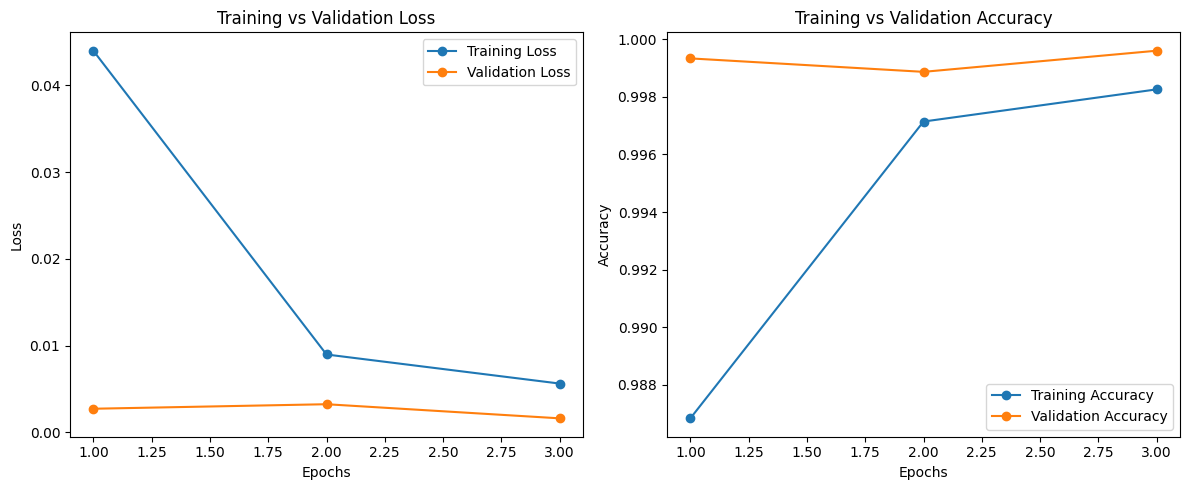

In [8]:
# ✅ Evaluate on Test Data
test_acc, test_loss = evaluate(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}")

# ✅ Plot Training History
plt.figure(figsize=(12, 5))

# Plot Losses
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), train_losses, label="Training Loss", marker="o")
plt.plot(range(1, EPOCHS + 1), val_losses, label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

# Plot Accuracies 
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), train_accs, label="Training Accuracy", marker="o")
plt.plot(range(1, EPOCHS + 1), val_accs, label="Validation Accuracy", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()